In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necssary libraries and modules

In [28]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

train_path = '/content/drive/MyDrive/Colab Notebooks/ML/Lab 1/train.csv'
valid_path = '/content/drive/MyDrive/Colab Notebooks/ML/Lab 1/valid.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/ML/Lab 1/test.csv'

train_data = pd.read_csv(train_path)
valid_data = pd.read_csv(valid_path)
test_data = pd.read_csv(test_path)

Drop the columns where there are null values for the lables in the training dataset

In [29]:
train_null_counts = train_data.isnull().sum()
print("train null counts : \n {}".format(train_null_counts))

train_data = train_data.dropna(subset=train_data.columns[-4:], how='any')

train_data = train_data.fillna(train_data.mean())

valid_data = valid_data.fillna(valid_data.mean())

test_data = test_data.fillna(test_data.mean())

train null counts : 
 feature_1        0
feature_2        0
feature_3        0
feature_4        0
feature_5        0
              ... 
feature_256      0
label_1          0
label_2        480
label_3          0
label_4          0
Length: 260, dtype: int64


Separate features and labels in the train, valid and test datasets

In [30]:
train_features = train_data.iloc[:, :-4]
train_labels = train_data.iloc[:, -4:]

valid_features = valid_data.iloc[:, :-4]
valid_labels = valid_data.iloc[:, -4:]

test_features = test_data.iloc[:, :-4]
test_labels = test_data.iloc[:, -4:]

train_label2 = train_labels.iloc[:,1]

valid_label2 = valid_labels.iloc[:,1]

test_label2 = test_labels.iloc[:,1]

# Predicting Label 2 without Feature Engineering

Predict label 2 without feature engineering steps and techniques

Make copies of the features and labels of the datasets to be used in the models without feature engineering

In [31]:
train_features_copy = train_features.copy()
train_labels_copy = train_labels.copy()

valid_features_copy = valid_features.copy()
valid_labels_copy = valid_labels.copy()

test_features_copy = test_features.copy()
test_labels_copy = test_labels.copy()

train_label2_copy = train_label2.copy()

valid_label2_copy = valid_label2.copy()

test_label2_copy = test_label2.copy()

Standardize the features of all datasets

In [32]:
scaler = StandardScaler()
train_features_copy = scaler.fit_transform(train_features_copy)
valid_features_copy = scaler.transform(valid_features_copy)
test_features_copy = scaler.transform(test_features_copy)

Use the raw scaled features to train the best model which is KNN Regressor

In [33]:
best_model = KNeighborsRegressor()

best_model.fit(train_features_copy, train_label2_copy)

KNeighborsRegressor()

Used the trained model on all features to predict the valid and get metrics

In [34]:
y_pred_base_train = best_model.predict(train_features_copy)

mse = mean_squared_error(train_label2_copy, y_pred_base_train)
r2s = r2_score(train_label2_copy, y_pred_base_train)

print(f"Metrics for KNeighborsRegressor on train data:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2s:.2f}")
print("\n")

y_pred_base_valid = best_model.predict(valid_features_copy)

mse = mean_squared_error(valid_label2_copy, y_pred_base_valid)
r2s = r2_score(valid_label2_copy, y_pred_base_valid)

print(f"Metrics for KNeighborsRegressor on valid data:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2s:.2f}")
print("\n")

Metrics for KNeighborsRegressor on train data:
Mean Squared Error: 0.38
R2 Score: 0.99


Metrics for KNeighborsRegressor on valid data:
Mean Squared Error: 0.67
R2 Score: 0.98




Predict the label 2 on test data

In [35]:
y_pred_base_test = best_model.predict(test_features_copy)

# Predicting Label 2 with Feature Engineering

Predict label 2 with feature engineering steps and techniques

## Feature Engineering

Use feature selection based on correlation matrix and feature extraction based on PCA

### Feature Selection

Visualize the distribution of the training label 2

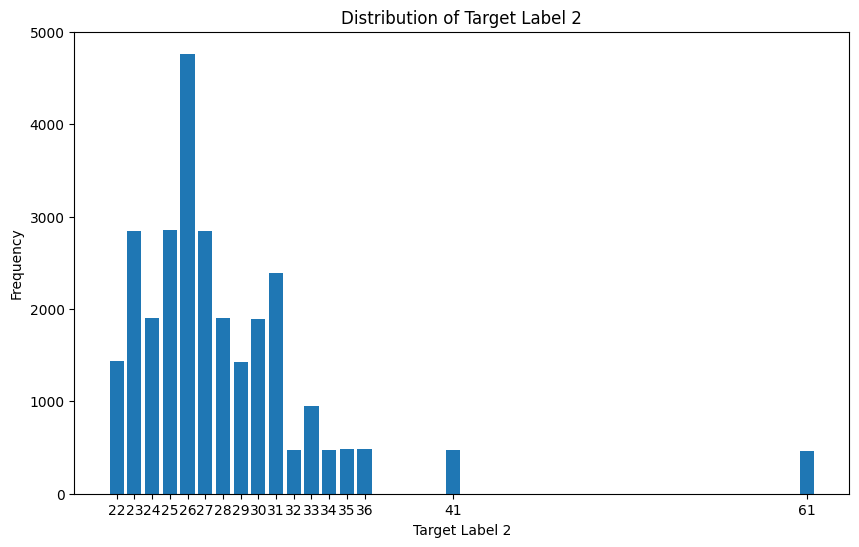

In [36]:
labels, counts = np.unique(train_label2, return_counts=True)

plt.figure(figsize=(10, 6))
plt.xticks(labels)
plt.bar(labels, counts)
plt.xlabel('Target Label 2')
plt.ylabel('Frequency')
plt.title('Distribution of Target Label 2')
plt.show()

Calculate the correlation matrix of the training data features

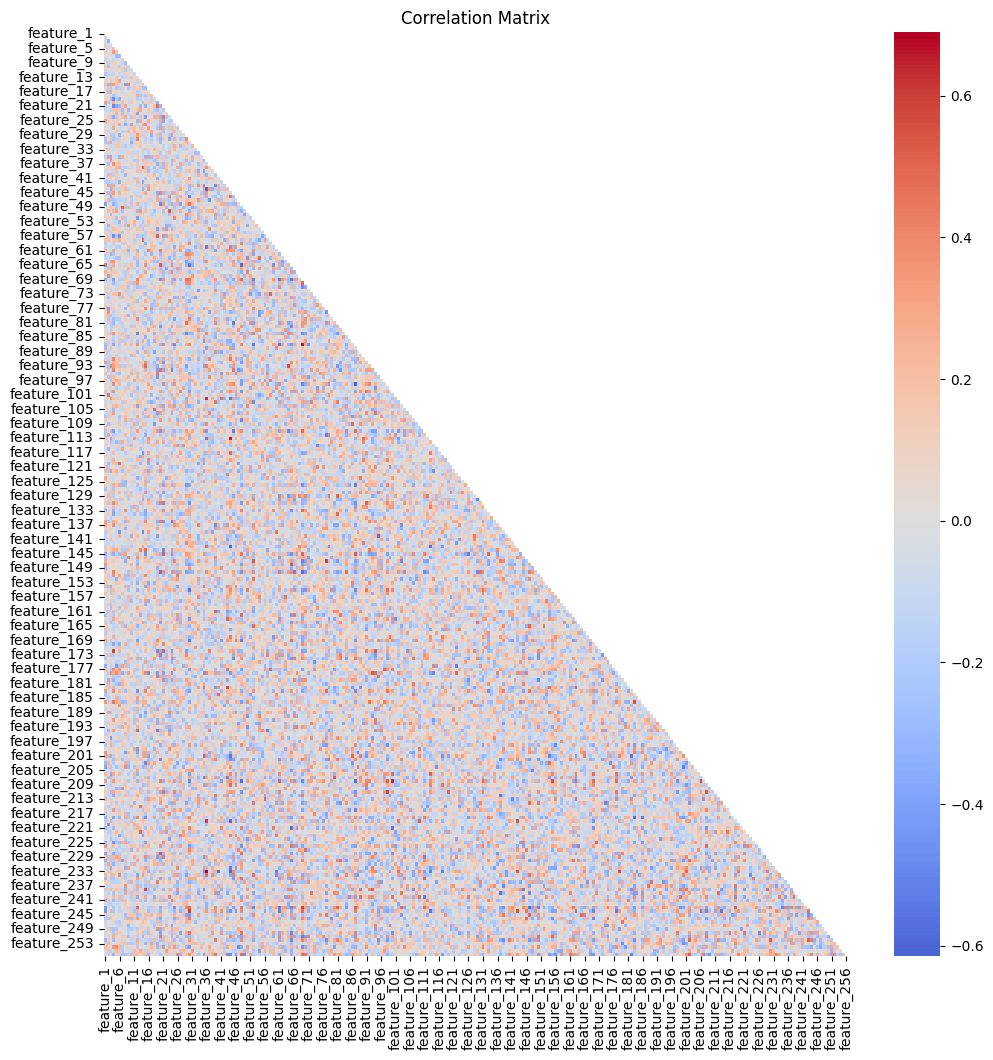

In [37]:
correlation_matrix = train_features.corr()

mask = np.triu(np.ones_like(correlation_matrix))

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, mask=mask)
plt.title("Correlation Matrix")
plt.show()

Identify the features that are highly correlated with each other using the traning dataset

In [38]:
correlation_threshold = 0.9

highly_correlated = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)


Remove the previously identified highly correlated features from all the datasets

In [39]:
train_features = train_features.drop(columns=highly_correlated)
valid_features = valid_features.drop(columns=highly_correlated)
test_features = test_features.drop(columns=highly_correlated)

correlation_with_target = train_features.corrwith(train_label2)

correlation_threshold = 0.05

highly_correlated_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold]

train_features = train_features[highly_correlated_features.index]

valid_features = valid_features[highly_correlated_features.index]

test_features = test_features[highly_correlated_features.index]

In [40]:
scaler = StandardScaler()
standardized_train_features = scaler.fit_transform(train_features)
standardized_valid_features = scaler.transform(valid_features)
standardized_test_features = scaler.transform(test_features)

### Feature Extraction

Explained Variance Ratio after Dimensionality Reduction: [0.09982753 0.091556   0.06283458 0.05278414 0.04911146 0.04640965
 0.04138797 0.03839171 0.03376594 0.02868479 0.02542208 0.02384038
 0.02247412 0.01955933 0.01839096 0.01757255 0.01618005 0.01608631
 0.01474531 0.01417676 0.01309584 0.0128583  0.01176045 0.01121314
 0.00997974 0.00961025 0.00901048 0.00860779 0.00837706 0.00786325
 0.0077597  0.00713651 0.00679999 0.00663594 0.00604778 0.00592182
 0.00575848 0.00539809 0.00518741 0.00501249 0.00484398 0.00460135
 0.00448294 0.00443335 0.00411771 0.00377323 0.00370858 0.00365106
 0.00326971 0.00312974 0.00297992 0.00283905 0.00281383 0.00268572
 0.00257712 0.00249861 0.00238258 0.00231694 0.00223059 0.00208596
 0.00200451 0.00179449 0.00170306 0.00168788 0.00159556 0.0014988
 0.00139146 0.00137077 0.00130053 0.00126    0.00118184 0.0011096
 0.00104643 0.00098532 0.000951   0.00092321 0.00091775 0.00084957
 0.00080863 0.00075644 0.00073209 0.00067917 0.00064488 0.00061174]


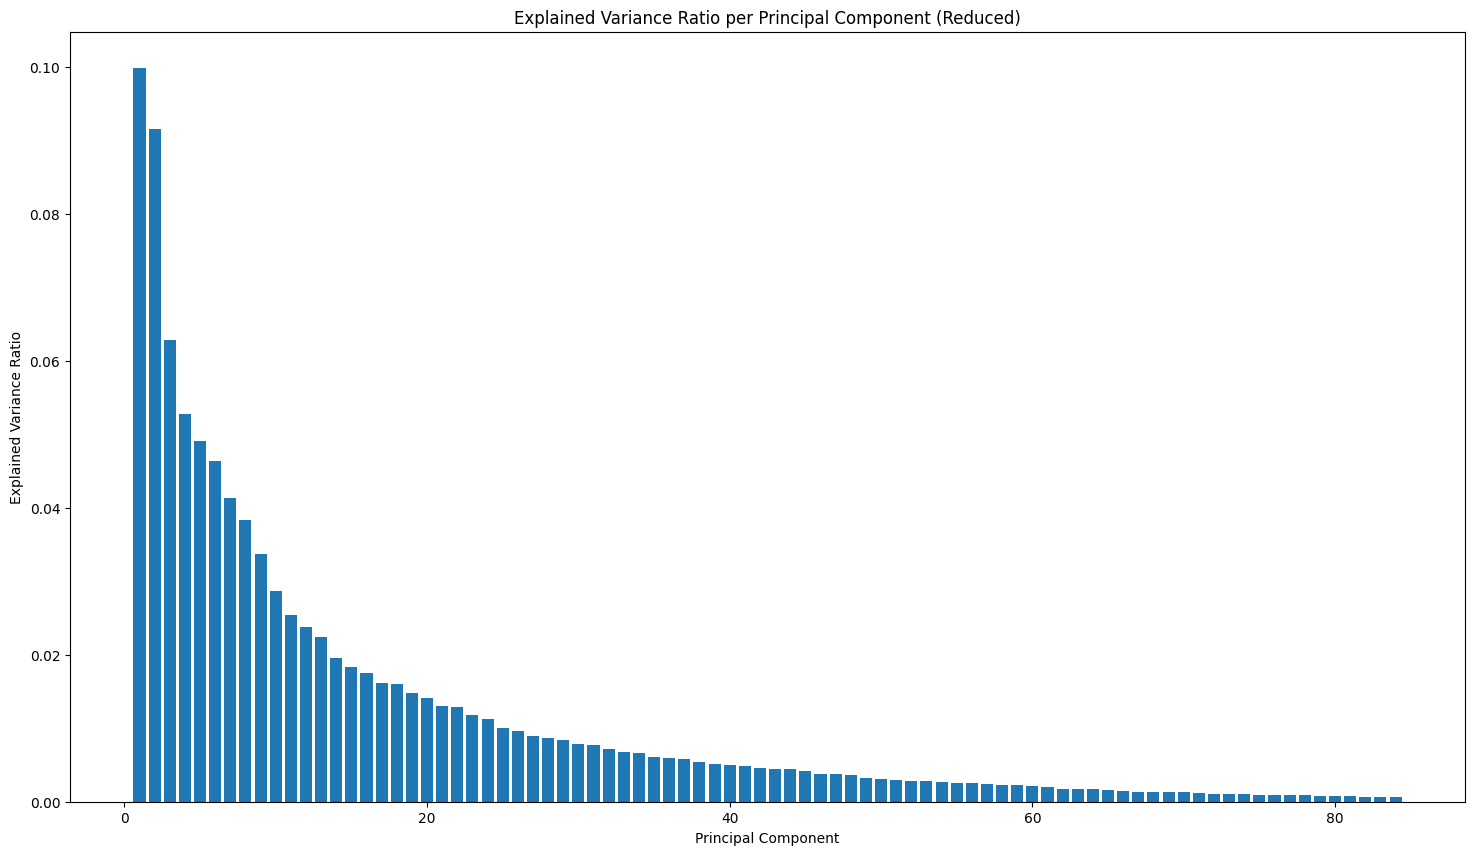

In [41]:
variance_threshold = 0.99

pca = PCA(n_components=variance_threshold, svd_solver='full')

pca_train_result = pca.fit_transform(standardized_train_features)
pca_valid_result = pca.transform(standardized_valid_features)
pca_test_result = pca.transform(standardized_test_features)

explained_variance_ratio_reduced = pca.explained_variance_ratio_
print("Explained Variance Ratio after Dimensionality Reduction:", explained_variance_ratio_reduced)

plt.figure(figsize=(18, 10))
plt.bar(range(1, pca_train_result.shape[1] + 1), explained_variance_ratio_reduced)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component (Reduced)')
plt.show()

## Model Selection

Select the model that best predicts the valid and test datasets based on root mean squared error and r2 score

In [42]:
classification_models = [
    # ('Linear Regression', LinearRegression()),
    ('K Neighbors', KNeighborsRegressor()),
    # ('Decision Tree', DecisionTreeRegressor()),
    # ('Random Forest', RandomForestRegressor()),
    # ('XGBoost', XGBRegressor())
]


num_features = pca_train_result.shape[1]
print(f"Number of features: {num_features}\n")

for model_name, model in classification_models:
    model.fit(pca_train_result, train_label2)

    y_pred_train = model.predict(pca_train_result)

    mse = mean_squared_error(train_label2, y_pred_train)
    r2s = r2_score(train_label2, y_pred_train)

    print(f"Metrics for {model_name} on train data:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R2 Score: {r2s:.2f}")
    print("\n")

    y_pred_valid = model.predict(pca_valid_result)

    mse = mean_squared_error(valid_label2, y_pred_valid)
    r2s = r2_score(valid_label2, y_pred_valid)

    print(f"Metrics for {model_name} on validation data:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R2 Score: {r2s:.2f}")
    print("\n")

    y_pred_test = model.predict(pca_test_result)


Number of features: 84

Metrics for K Neighbors on train data:
Mean Squared Error: 0.54
R2 Score: 0.98


Metrics for K Neighbors on validation data:
Mean Squared Error: 1.10
R2 Score: 0.97




# Generate Output CSV

Define method to create the csv file

In [46]:
def create_csv(features, pred_before_fe, pred_after_fe, destination):
  feature_count = features.shape[1]

  header_row = [f"new_feature_{i}" for i in range(1,feature_count+1)]

  df = pd.DataFrame(features, columns  = header_row)

  df.insert(loc=0, column='Predicted labels before feature engineering', value=pred_before_fe)
  df.insert(loc=1, column='Predicted labels after feature engineering', value=pred_after_fe)
  df.insert(loc=2, column='No of new features', value=np.repeat(feature_count, features.shape[0]))

  df.to_csv(destination, index=False)

Create CSV file

In [47]:
destination = '/content/drive/MyDrive/Colab Notebooks/ML/Lab 1/190493U_label_2.csv'

create_csv(pca_test_result, y_pred_base_test, y_pred_test, destination)